<a href="https://colab.research.google.com/github/mrella/opendata/blob/main/datos_plataforma_contrataci%C3%B3n_espa%C3%B1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRATAMIENTO Y ANÁLISIS DE LAS LICITACIONES DE LA PLATAFORMA DE CONTRATACIÓN DEL SECTOR PÚBLICO DE ESPAÑA  

Ver ejemplos de resultados y de su tratamiento con IA al final...

---------


Objetivo obtener 1 único registro por licitación a partir de procesar todas las transacciones codice disponibles sobre el mismo informadas en los "datos abiertos" del Ministerio.

Si tienes comentarios los puedes poner [AQUÍ](https://www.linkedin.com/feed/update/urn:li:activity:7327973558922403841/) donde también está un poco el making-of...


In [ ]:
import os
import requests
import zipfile
import xml.etree.ElementTree as ET
import csv
import pandas as pd
from xml.etree.ElementTree import ParseError

# Descarga de los datos de contratación desde el Ministerio de Hacienda

In [ ]:
##################################
### PARAMETROS INICIALES       ###
##################################

anualidad                  = '2025'  # PON AQUÍ LA ANUALIDAD A TRATAR


In [ ]:
##################################
### DESCARGA DE CODICE         ###
##################################

path_ficheros_codice       = f'./codice_{anualidad}'
path_licitaciones_csv      = f'./licitaciones_platataforma_contratacion_sector_publico_{anualidad}.csv'

def descargar_codice(anualidad, path_ficheros_codice):

    urls_codice = [
    f"https://contrataciondelsectorpublico.gob.es/sindicacion/sindicacion_643/licitacionesPerfilesContratanteCompleto3_{anualidad}.zip",
    f"https://contrataciondelsectorpublico.gob.es/sindicacion/sindicacion_1044/PlataformasAgregadasSinMenores_{anualidad}.zip"
    ]

    print(f"Iniciando descarga de archivos codice {anualidad}...")

    os.makedirs(path_ficheros_codice, exist_ok=True)

    for url in urls_codice:

        filename = os.path.basename(url)
        zip_path = os.path.join(path_ficheros_codice, filename)

        print(f"Descargando {filename}...")
        response = requests.get(url)
        response.raise_for_status()

        with open(zip_path, "wb") as f:
            f.write(response.content)
        print(f"{filename} descargado correctamente.")

        print(f"Descomprimiendo {filename}...")
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(path_ficheros_codice)
        print(f"{filename} descomprimido en {path_ficheros_codice}.\n")


descargar_codice(anualidad, path_ficheros_codice)

Iniciando descarga de archivos codice 2025...
Descargando licitacionesPerfilesContratanteCompleto3_2025.zip...
None
licitacionesPerfilesContratanteCompleto3_2025.zip descargado correctamente.
Descomprimiendo licitacionesPerfilesContratanteCompleto3_2025.zip...
licitacionesPerfilesContratanteCompleto3_2025.zip descomprimido en ./codice_2025.

Descargando PlataformasAgregadasSinMenores_2025.zip...
None
PlataformasAgregadasSinMenores_2025.zip descargado correctamente.
Descomprimiendo PlataformasAgregadasSinMenores_2025.zip...
PlataformasAgregadasSinMenores_2025.zip descomprimido en ./codice_2025.



# Procesamiento y consolidación de los contratos

In [ ]:
##################################
### PROCESAMIENTO              ###
##################################

def safe_find_text(element, path, namespaces, default=''):
    found = element.find(path, namespaces)
    return found.text if found is not None else default

def safe_find_attr(element, path, attr, namespaces, default=''):
    found = element.find(path, namespaces)
    return found.attrib.get(attr, default) if found is not None else default

def parse_codice_xml_to_csv(anualidad, licitaciones, path_archivo_codice):
    # Definir los namespaces
    namespaces = {
        'atom': 'http://www.w3.org/2005/Atom',
        'cbc': 'urn:dgpe:names:draft:codice:schema:xsd:CommonBasicComponents-2',
        'cac': 'urn:dgpe:names:draft:codice:schema:xsd:CommonAggregateComponents-2',
        'cbc-place-ext': 'urn:dgpe:names:draft:codice-place-ext:schema:xsd:CommonBasicComponents-2',
        'cac-place-ext': 'urn:dgpe:names:draft:codice-place-ext:schema:xsd:CommonAggregateComponents-2'
    }

    try:
        # Parsear el XML
        tree = ET.parse(path_archivo_codice)
        root = tree.getroot()

        # Abrir archivo CSV para escritura

        # Procesar cada entrada
        for entry in root.findall('atom:entry', namespaces):

                # Información básica
                title   = safe_find_text(entry, 'atom:title', namespaces)
                updated = safe_find_text(entry, 'atom:updated', namespaces)
                url = safe_find_attr(entry, 'atom:link', 'href', namespaces)

                # Información detallada
                contract = entry.find('cac-place-ext:ContractFolderStatus', namespaces)
                if contract is None:
                    continue

                id_licitacion = safe_find_text(contract, 'cbc:ContractFolderID', namespaces)
                estado = safe_find_text(contract, 'cbc-place-ext:ContractFolderStatusCode', namespaces)


                # Datos de la licitación
                # Datos del órgano de contratación
                contracting_party = contract.find('cac-place-ext:LocatedContractingParty', namespaces)
                #nif = ''
                if contracting_party is not None:
                    nif = safe_find_text(contracting_party, './/cbc:ID[@schemeName="NIF"]', namespaces)
                    dir3 = safe_find_text(contracting_party, './/cbc:ID[@schemeName="DIR3"]', namespaces)
                    organo = safe_find_text(contracting_party, 'cac:Party/cac:PartyName/cbc:Name', namespaces)
                    address = contracting_party.find('.//cac:PostalAddress', namespaces)
                    direccion = safe_find_text(address, 'cac:AddressLine/cbc:Line', namespaces) if address is not None else ''
                    localidad = safe_find_text(address, 'cbc:CityName', namespaces) if address is not None else ''
                    codigo_postal = safe_find_text(address, 'cbc:PostalZone', namespaces) if address is not None else ''
                    contacto = contracting_party.find('.//cac:Contact', namespaces)
                    telefono = safe_find_text(contacto, 'cbc:Telephone', namespaces) if contacto is not None else ''
                    email = safe_find_text(contacto, 'cbc:ElectronicMail', namespaces) if contacto is not None else ''
                else:
                    nif = direccion = localidad = codigo_postal = telefono = email = dir3 = organizacion = ''

                # Datos del proyecto
                project = contract.find('cac:ProcurementProject', namespaces)
                if project is not None:
                    tipo_contrato = safe_find_text(project, 'cbc:TypeCode', namespaces)
                    subtipo_contrato = safe_find_text(project, 'cbc:SubTypeCode', namespaces)
                    cpv = safe_find_text(project, './/cbc:ItemClassificationCode', namespaces)

                    # Presupuesto
                    budget = project.find('cac:BudgetAmount', namespaces)
                    importe_total = safe_find_text(budget, 'cbc:TotalAmount', namespaces) if budget is not None else ''
                    importe_sin_iva = safe_find_text(budget, 'cbc:TaxExclusiveAmount', namespaces) if budget is not None else ''

                    # Periodo
                    planned_period = project.find('cac:PlannedPeriod', namespaces)
                    fecha_inicio = safe_find_text(planned_period, 'cbc:StartDate', namespaces) if planned_period is not None else ''
                    duracion = safe_find_text(planned_period, 'cbc:DurationMeasure', namespaces) if planned_period is not None else ''
                else:
                    tipo_contrato = subtipo_contrato = cpv = importe_total = importe_sin_iva = fecha_inicio = duracion = ''

                # Lotes
                lots = contract.findall('cac:ProcurementProjectLot', namespaces)
                num_lotes = len(lots)

                # Tendering process

                # Dentro del procesamiento de cada entry, después de procesar contract:
                tendering_process = contract.find('cac:TenderingProcess', namespaces)
                if tendering_process is not None:
                    procedure_code = safe_find_text(tendering_process, 'cbc:ProcedureCode', namespaces)
                    urgency_code = safe_find_text(tendering_process, 'cbc:UrgencyCode', namespaces)
                    part_presentation = safe_find_text(tendering_process, 'cbc:PartPresentationCode', namespaces)
                    contracting_system = safe_find_text(tendering_process, 'cbc:ContractingSystemCode', namespaces)
                    submission_method = safe_find_text(tendering_process, 'cbc:SubmissionMethodCode', namespaces)
                    max_lot_presentation = safe_find_text(tendering_process, 'cbc:MaximumLotPresentationQuantity', namespaces)
                    max_lot_awarded = safe_find_text(tendering_process, 'cbc:MaximumTendererAwardedLotsQuantity', namespaces)

                    doc_availability = tendering_process.find('cac:DocumentAvailabilityPeriod', namespaces)
                    doc_end_date = safe_find_text(doc_availability, 'cbc:EndDate', namespaces) if doc_availability is not None else ''
                    doc_end_time = safe_find_text(doc_availability, 'cbc:EndTime', namespaces) if doc_availability is not None else ''
                    doc_availability_end = f"{doc_end_date} {doc_end_time}".strip()

                    submission_deadline = tendering_process.find('cac:TenderSubmissionDeadlinePeriod', namespaces)
                    sub_end_date = safe_find_text(submission_deadline, 'cbc:EndDate', namespaces) if submission_deadline is not None else ''
                    sub_end_time = safe_find_text(submission_deadline, 'cbc:EndTime', namespaces) if submission_deadline is not None else ''
                    submission_end = f"{sub_end_date} {sub_end_time}".strip()
                else:
                    procedure_code = urgency_code = part_presentation = contracting_system = ''
                    submission_method = max_lot_presentation = max_lot_awarded = ''
                    doc_availability_end = submission_end = ''

                # Resultados de la licitación (adjudicación)
                tender_results = contract.findall('cac:TenderResult', namespaces)
                empresa_adjudicataria = nif_adjudicatario = importe_adjudicado = num_ofertas = fecha_adjudicacion = ''

                if tender_results:
                    first_result = tender_results[0]
                    winning_party = first_result.find('cac:WinningParty', namespaces)
                    if winning_party is not None:
                        empresa_adjudicataria = safe_find_text(winning_party, 'cac:PartyName/cbc:Name', namespaces)
                        nif_adjudicatario = safe_find_text(winning_party, 'cac:PartyIdentification/cbc:ID', namespaces)

                    awarded_project = first_result.find('cac:AwardedTenderedProject', namespaces)
                    if awarded_project is not None:
                        importe_adjudicado = safe_find_text(awarded_project, './/cbc:PayableAmount', namespaces)

                    num_ofertas = safe_find_text(first_result, 'cbc:ReceivedTenderQuantity', namespaces)
                    fecha_adjudicacion = safe_find_text(first_result, 'cbc:AwardDate', namespaces)

                # Criterios de adjudicación
                awarding_criteria = []
                awarding_terms = contract.find('.//cac:AwardingTerms', namespaces)
                if awarding_terms is not None:
                    for criteria in awarding_terms.findall('cac:AwardingCriteria', namespaces):
                        desc = safe_find_text(criteria, 'cbc:Description', namespaces)
                        weight = safe_find_text(criteria, 'cbc:WeightNumeric', namespaces)
                        if desc:
                            awarding_criteria.append(f"{desc} ({weight}%)" if weight else desc)

                criterios = "; ".join(awarding_criteria)


                # Obtencion la fecha de publicación del DOC_CN
                valid_notices = contract.findall('cac-place-ext:ValidNoticeInfo', namespaces)
                fecha_doc_cn_date = fecha_formalizacion = fecha_adjudicacion = ''

                if valid_notices:
                    for notice in valid_notices:
                        notice_type = notice.find('cbc-place-ext:NoticeTypeCode', namespaces)
                        if notice_type is not None and notice_type.text == 'DOC_CN':
                            pub_status = notice.find('cac-place-ext:AdditionalPublicationStatus', namespaces)
                            if pub_status is not None:
                                first_date_ref = pub_status.find('cac-place-ext:AdditionalPublicationDocumentReference', namespaces)
                                if first_date_ref is not None:
                                    issue_date = first_date_ref.find('cbc:IssueDate', namespaces)
                                    if issue_date is not None and issue_date.text:
                                        fecha_doc_cn_date = issue_date.text

                        if notice_type is not None and notice_type.text == 'DOC_CAN_ADJ':
                            pub_status = notice.find('cac-place-ext:AdditionalPublicationStatus', namespaces)
                            if pub_status is not None:
                                first_date_ref = pub_status.find('cac-place-ext:AdditionalPublicationDocumentReference', namespaces)
                                if first_date_ref is not None:
                                    issue_date = first_date_ref.find('cbc:IssueDate', namespaces)
                                    if issue_date is not None and issue_date.text:
                                        fecha_adjudicacion = issue_date.text

                        if notice_type is not None and notice_type.text == 'DOC_FORM':
                            pub_status = notice.find('cac-place-ext:AdditionalPublicationStatus', namespaces)
                            if pub_status is not None:
                                first_date_ref = pub_status.find('cac-place-ext:AdditionalPublicationDocumentReference', namespaces)
                                if first_date_ref is not None:
                                    issue_date = first_date_ref.find('cbc:IssueDate', namespaces)
                                    if issue_date is not None and issue_date.text:
                                        fecha_formalizacion = issue_date.text


                clave = f"{anualidad}-{organo}-{id_licitacion}"

                row = [
                        anualidad, updated, estado, id_licitacion, title, organo, nif, dir3,
                        direccion, localidad, codigo_postal, telefono, email,
                        tipo_contrato, subtipo_contrato, cpv, importe_total.replace('.',','),
                        importe_sin_iva.replace('.',','),importe_adjudicado.replace('.',','), fecha_inicio, duracion, num_lotes,
                        empresa_adjudicataria, nif_adjudicatario,
                        num_ofertas, fecha_doc_cn_date, fecha_adjudicacion, fecha_formalizacion, criterios,
                        url,  procedure_code, urgency_code, part_presentation,
                        contracting_system, submission_method, max_lot_presentation,
                        max_lot_awarded, doc_availability_end, submission_end
                ]

                #CONSOLIDACION DE LICITACIONES CON LA MISMA CLAVE
                #Si existe la licitación la actualizamos si el registro es más nuevo
                if licitaciones.get(clave,'') != '':
                    if licitaciones[clave][1] < updated:
                        #print ("ROW OLD -> " + str(licitaciones.get(clave,'')))
                        licitaciones[clave] = row
                        #print ("ROW NEW -> " + str(row))

                #Si no existe la licitación la insertamos en el diccionario
                if licitaciones.get(clave,'') == '':
                    licitaciones[clave] = row


    except ParseError as e:
        print(f"Error al parsear el XML: {e}")
    #except Exception as e:
        #print(f"Error inesperado: {e}")


def procesar_directorio_codice(anualidad, path_ficheros_codice, path_licitaciones_csv):

    licitaciones = {}

    # Obtener lista de archivos XML en el directorio y ordenarlos
    archivos_xml = sorted([f for f in os.listdir(path_ficheros_codice) if f.lower().endswith('.atom')])

    if not archivos_xml:
        print(f"No se encontraron archivos XML en el directorio: {path_ficheros_codice}")
        return

    print(f"Procesando {len(archivos_xml)} archivos XML en orden alfabético...")

    # Procesar el resto de archivos sin encabezados
    for archivo in archivos_xml:  #[1:]
        path_archivo_codice = os.path.join(path_ficheros_codice, archivo)
        parse_codice_xml_to_csv(anualidad, licitaciones, path_archivo_codice)

    print(f"Todos los archivos procesados en orden alfabético.")

    print(f"Reordenando licitaciones...")

    # Convertir el diccionario a dataframe
    datos = list(licitaciones.values())

    header = [
                    'EXERCICI','DATA_ACTUALITZACIO','SITUACIO_CONTRACTUAL','CODI_EXPEDIENT',
                    'DESCRIPCIO_EXPEDIENT', 'ORGANISME_CONTRACTANT',
                    'ID_ORGANISME_CONTRACTANT_NIF', 'ID_ORGANISME_CONTRACTANT_DIR3',
                    'DIRECCIO', 'LOCALITAT', 'CODI_POSTAL', 'CODI_POSTAL', 'EMAIL',
                    'TIPUS_CONTRACTE', 'SUBTIPUS_CONTRACTE', 'CODI_CPV', 'IMPORT_TOTAL',
                    'IMPORT_SENSE_IVA', 'IMPORT_ADJUDICACIO', 'DATA_INICI', 'MESOS_DURADA',
                    'NUMERO_LOT', 'ADJUDICATARI', 'ADJUDICATARI_NIF',
                    'NUMERO_OFERTES', 'DATA_PUBLICACIO_CN', 'DATA_ADJUDICACIO', 'DATA_FORMALITZACIO',
                    'CRITERIS_ADJUDICACIO', 'URL', 'CODI_PROCEDIMENT', 'CODI_URGENCIA', 'PRESENTACIO_PARTS',
                    'SISTEMA_CONTRACTACIO', 'METODE_ENVIAMENT', 'MAX_LOTS_PRESENTACIO',
                    'MAX_LOTS_ADJUDICACIO', 'FI_DISPONIBILITAT_DOCS',
                    'FI_TERMINI_PRESENTACIO'
            ]

    df = pd.DataFrame(datos, columns=header)
    df = df.sort_values(by=["ORGANISME_CONTRACTANT", "CODI_EXPEDIENT"], ascending=[True, True])
    df.to_csv(path_licitaciones_csv, index=False, encoding='utf-8-sig', sep=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    print(f"Resultados CSV totales guardados en: {path_licitaciones_csv}")


    ### PARA TRATARLO CON NOTEBOOKLM SE GENERAN N-FICHEROS DE TEXTO QUE SE PUEDEN IMPORTAR DESPUÉS EN NOTEBOOKLM
    f = open(path_licitaciones_csv+'.txt', mode='w', encoding='utf-8-sig')
    i = ii = 0
    for _, fila in df.iterrows():

        descripcion = fila["DESCRIPCIO_EXPEDIENT"]
        organismo = fila["ORGANISME_CONTRACTANT"]
        importe = fila["IMPORT_SENSE_IVA"]
        adjudicatario = fila["ADJUDICATARI"]
        adjudicatario_nif = fila["ADJUDICATARI_NIF"]

        f.write(f"Descripcion del contrato: {descripcion}, Contratado por: {organismo}, Importe sin IVA {importe}, Adjudicado a: {adjudicatario} (NIF: {adjudicatario_nif} \n\n")
        i += 1

        if i % 5000 == 0:
            ii += 1
            f.close()
            f = open(path_licitaciones_csv+f'_{ii}.txt', mode='w', encoding='utf-8-sig')

    print(f"Resultados parciales para notebooklm guardados en: {path_licitaciones_csv}.txt")
    print("Fin del proceso")
    ###


# Verificar si el directorio existe
if not os.path.isdir(path_ficheros_codice):
    print(f"El directorio no existe: {path_ficheros_codice}")
else:
    procesar_directorio_codice(anualidad, path_ficheros_codice, path_licitaciones_csv)



Procesando 755 archivos XML en orden alfabético...
Todos los archivos procesados en orden alfabético.
Reordenando licitaciones...
Resultados CSV totales guardados en: ./licitaciones_platataforma_contratacion_sector_publico_2025.csv
Resultados parciales para notebooklm guardados en: ./licitaciones_platataforma_contratacion_sector_publico_2025.csv.txt
Fin del proceso


Cuando acabe el paso anterior aparecerá "Fin del proceso" en pantalla.

EL CSV CON TODOS LOS CONTRATOS se podrá bajar en la carpeta de la derecha y se podrá analizar en excel o importar en un power BI para análisis cuantitativos:

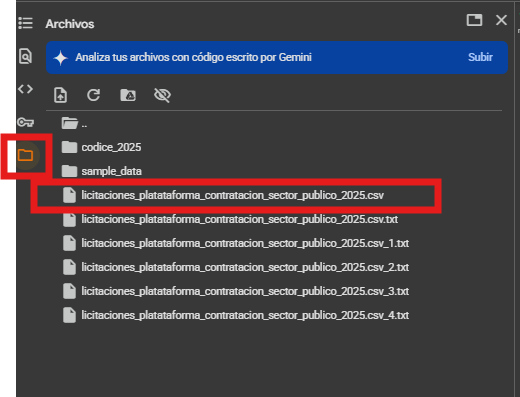


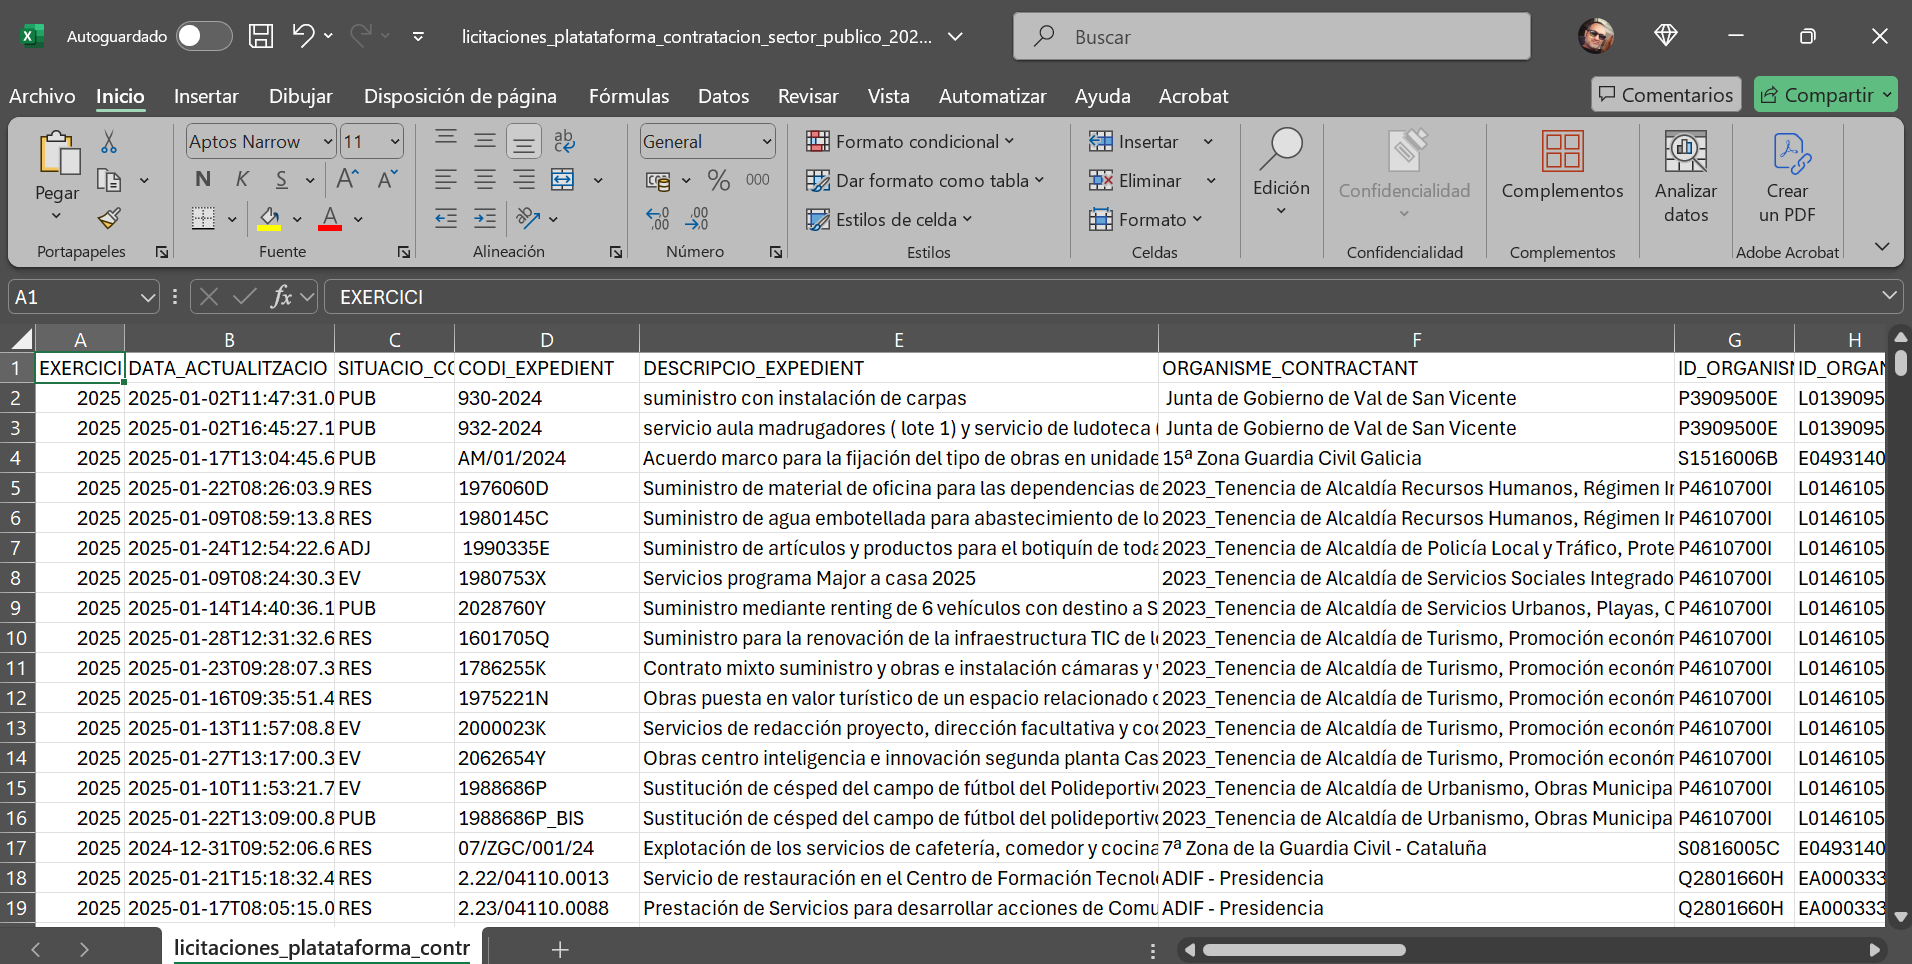

También tendrás n-ficheros con extensión de texto .txt, que contendrán datos básicos (título, importe, organo, adjudicatario) que podrás importar fácilmente en  https://notebooklm.google.com/ de google para realizar analisis cualitativo con inteligencia artificial:

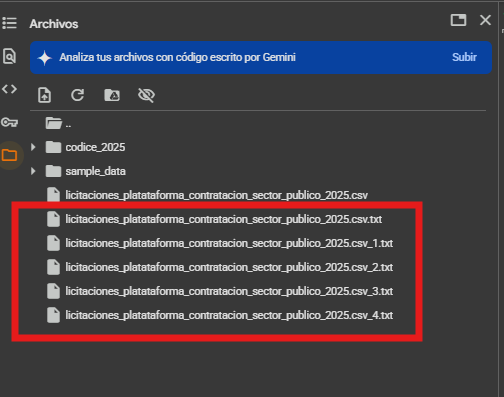





Por ejemplo podrás generar mapas conceptuales: 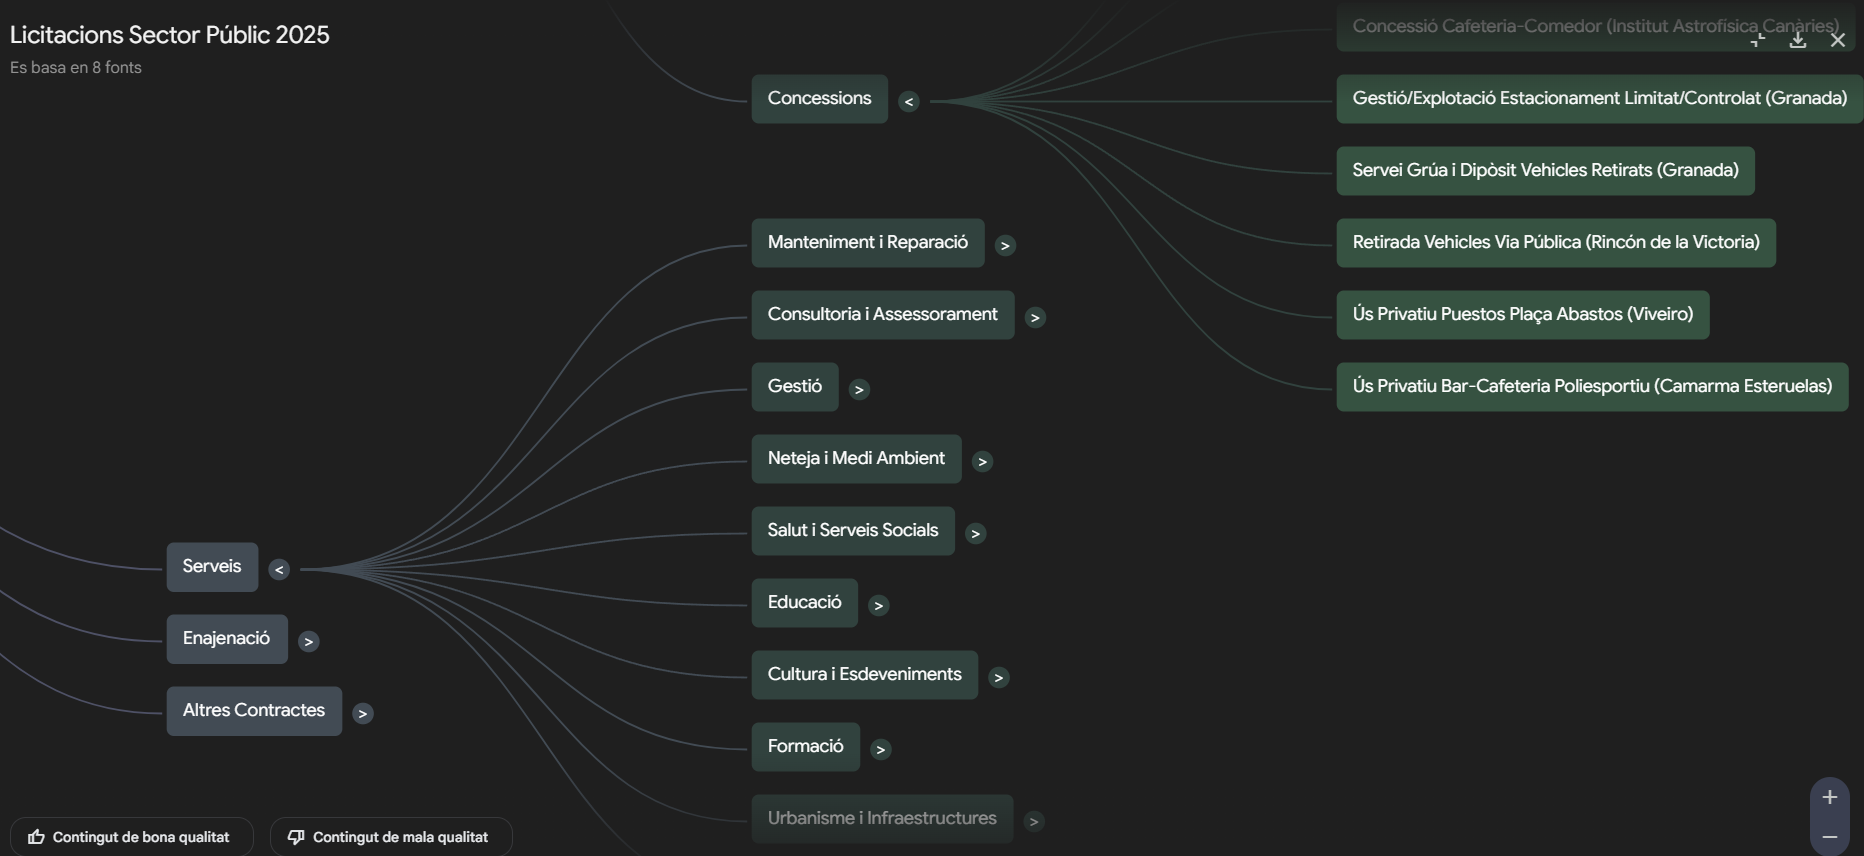


Y cuando cliques en una etiqueta te llevará a los contratos en cuestión:

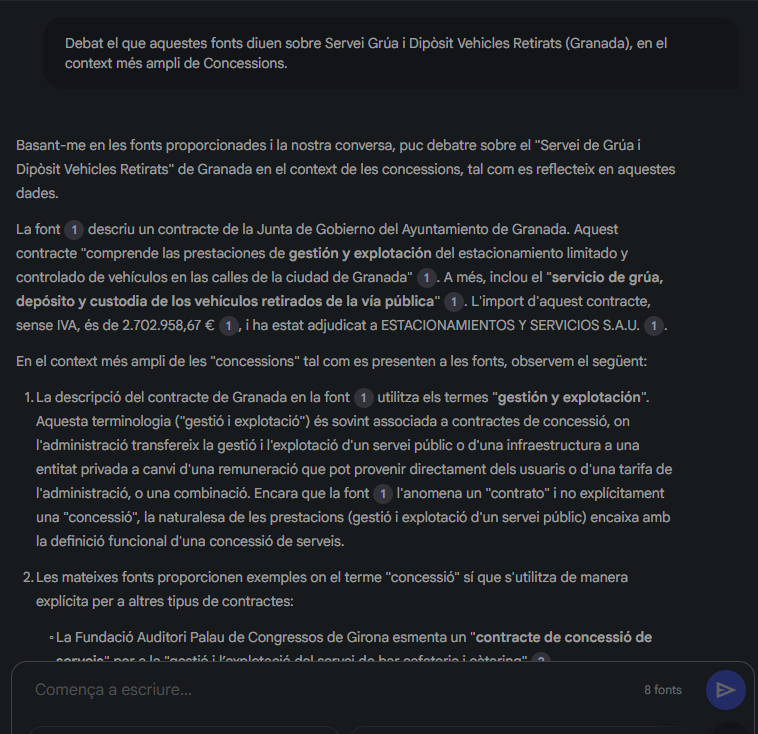


O que te describa las contrataciones principales de un organismo:


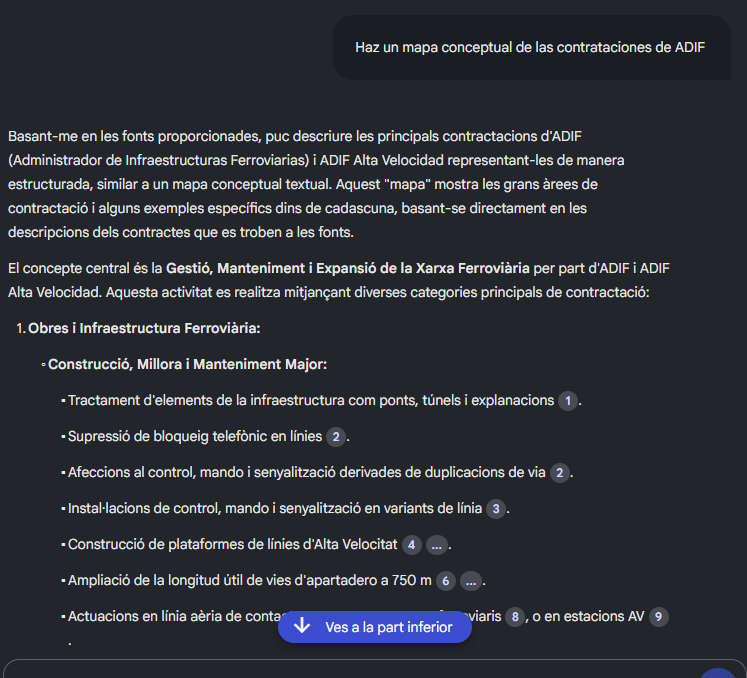


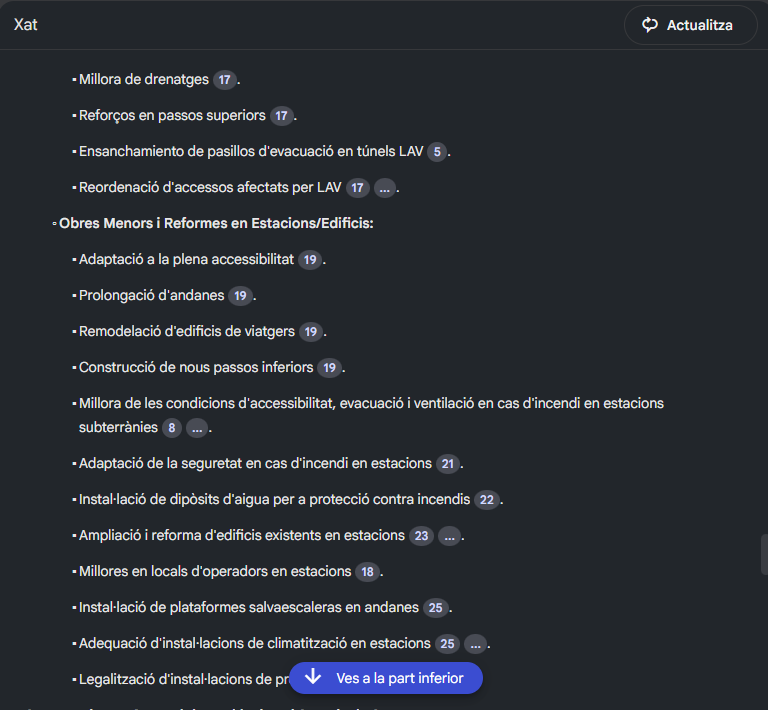

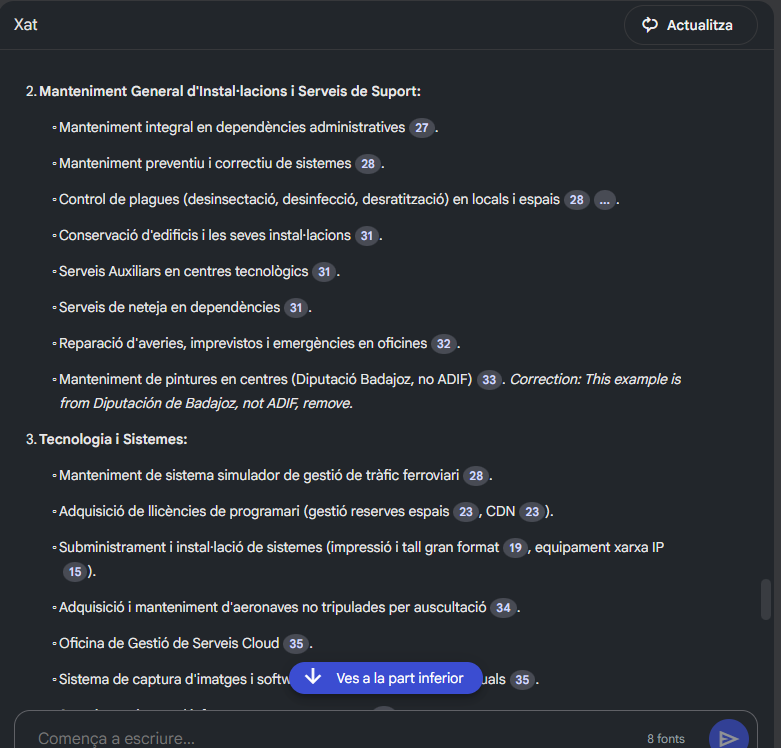

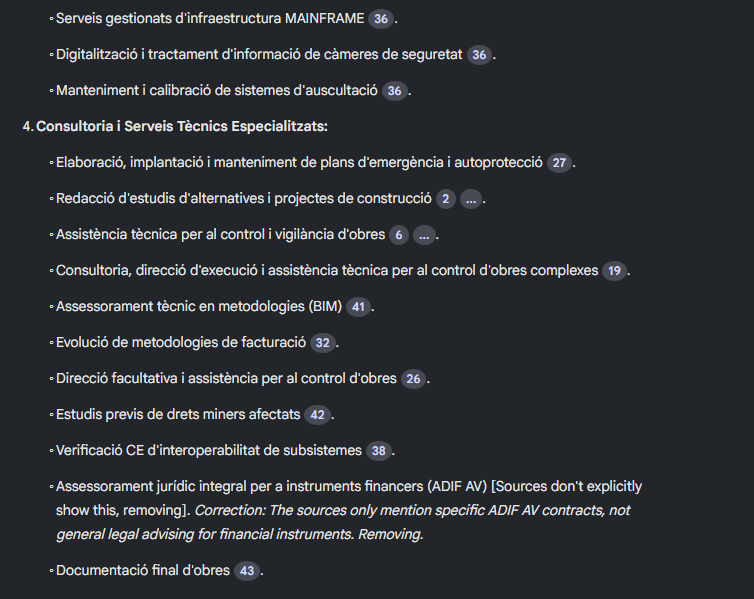


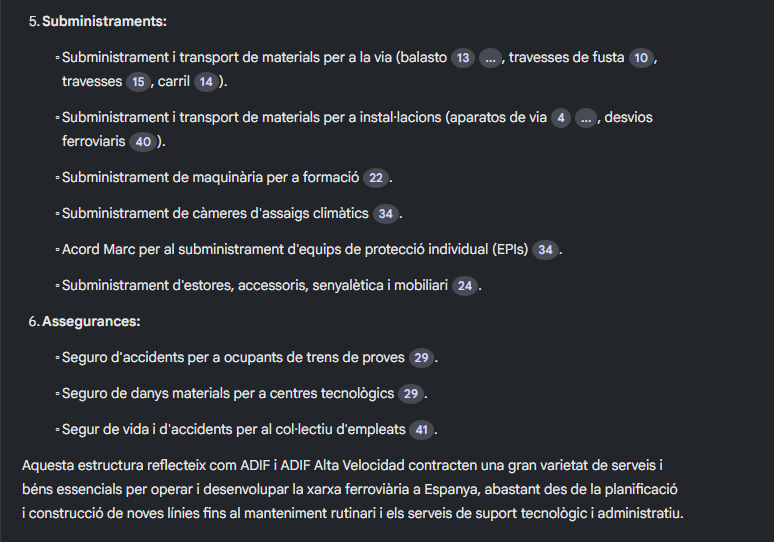

Y siempre pudiendo ir a la fuente original a ver exactamente el contrato en cuestión:

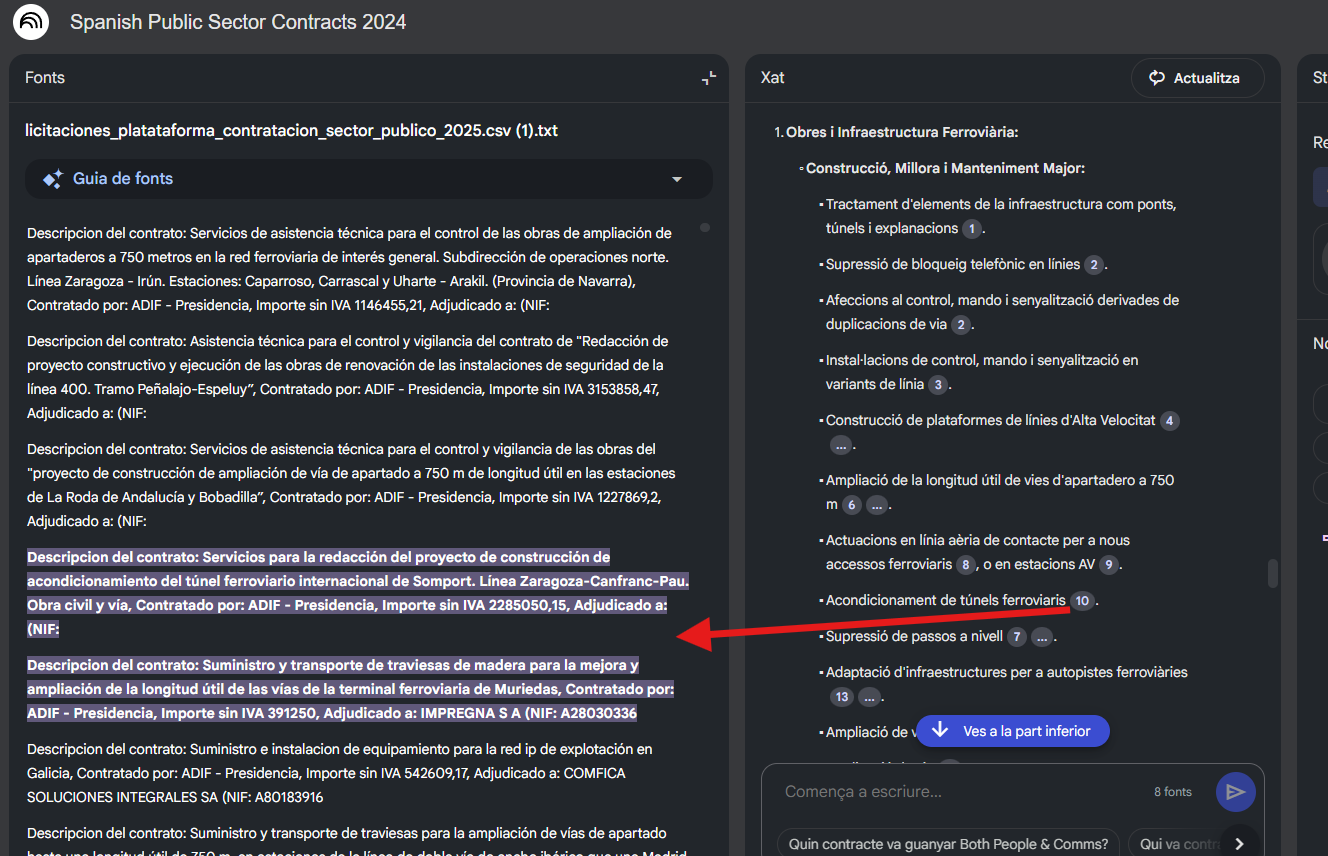

Podrás pedirle por ejemplo que te compare dos ayuntamientos:

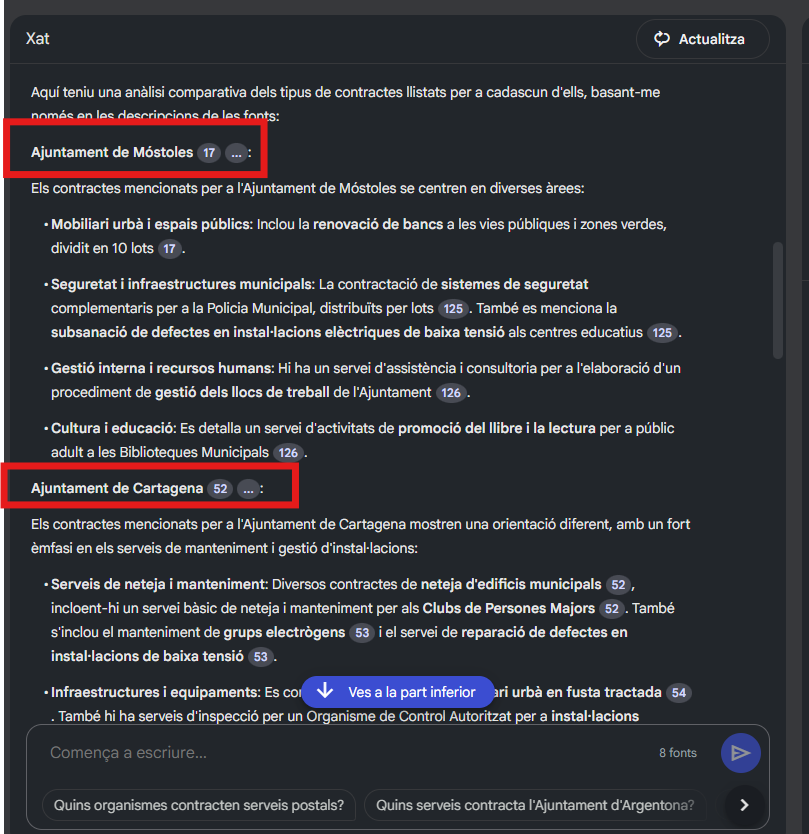


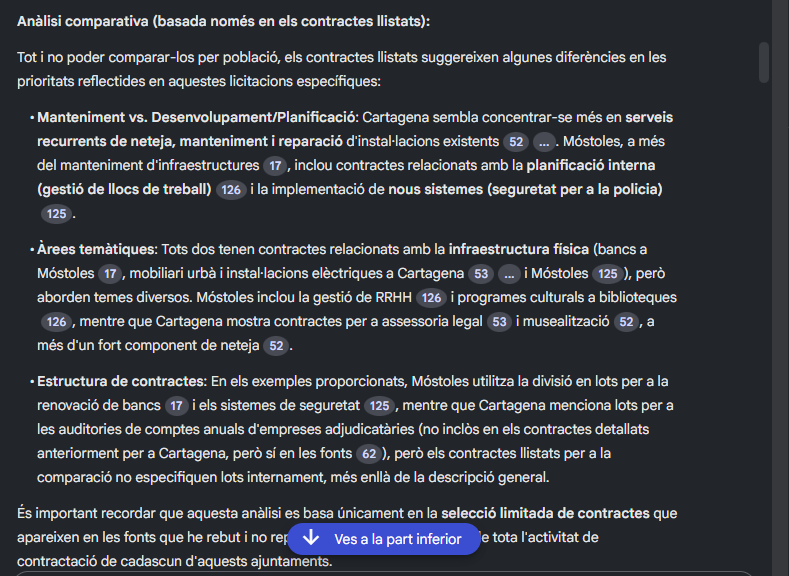


O que te detecte posibles anomalias:

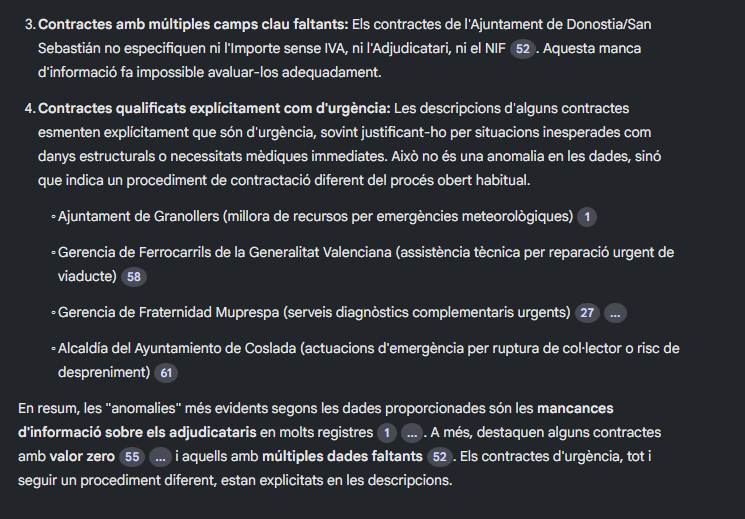

Incluso podrás crear un PODCAST en el idioma que quieras: https://notebooklm.google.com/notebook/9255a5d4-3566-4c92-8c6f-b27fb33008d0/audio

OTRO EJEMPLO PRÁCTICO CON LA APP MÓVIL DE NOTEBOOKLM:

In [ ]:
#Video de ejemplo analizando los contratos de Paiporta por la DANA desde la nueva APP de notebooklm

%%html
<iframe width="380" height="700" src="https://www.youtube.com/embed/QPhy3EKhRNA" frameborder="0" allowfullscreen></iframe>

Testeando flourish.studio con un subconjunto de contratos en licitación,

corona exterior es el objeto del contrato, bolitas interiores los organismos que contratan:

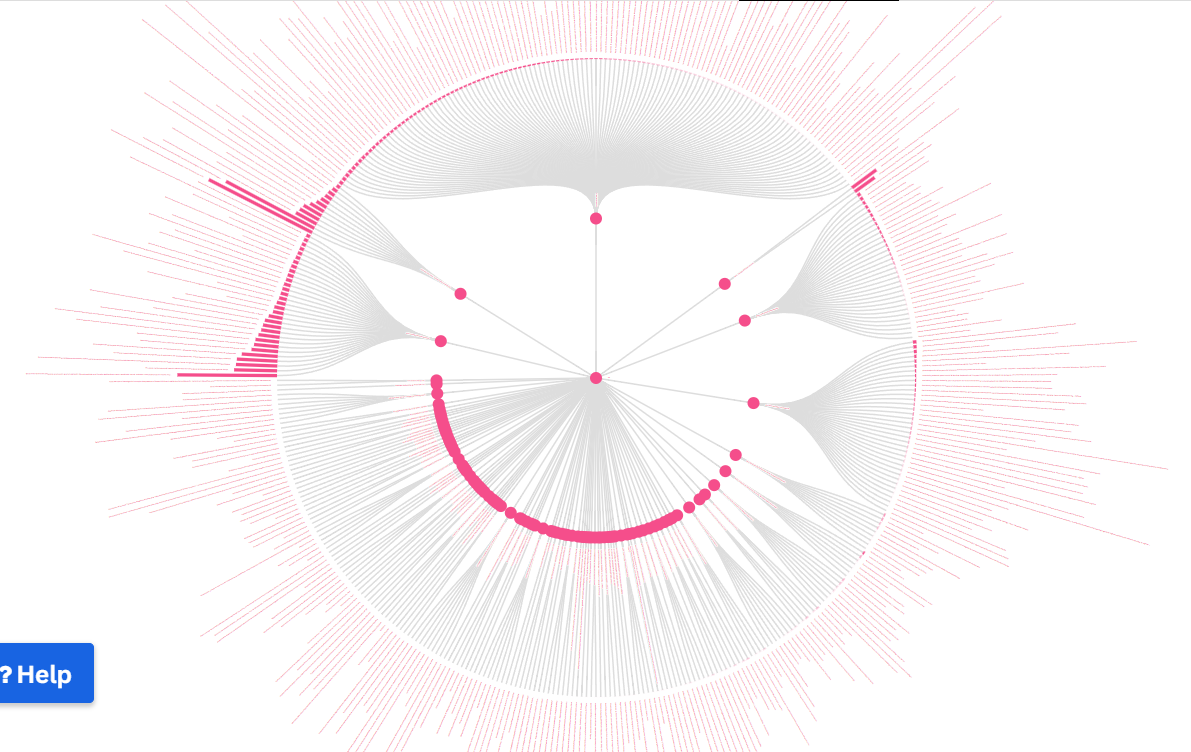